# Human PBMCs from Freytag et al.

Here we analyse the PBMCs from a healthy donor (v2 chemistry)(Cell Ranger 2.0.0) published by [Freytag et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6124389/)
Link to the dataset: [GSE115189](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=gse115189)

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4+6.ge614f59 anndata==0.6.22.post1 umap==0.3.9 numpy==1.15.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
# install some R packages through rpy2 (the rest are installed via conda)
packnames = ('RColorBrewer', 'gam', 'ggplot2', 'plyr')
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))
results_file = './write/Freytag_pbmcs.h5ad'  # the file that will store the analysis results

In [4]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
#library(slingshot)
#library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

In [6]:
## Load previously processed dataset
#adata = sc.read_h5ad(results_file)

In [33]:
# Set up data loading
file = '../../Munich/datasets/human/Freytag_PBMC/GSM3169075_filtered_gene_bc_matrices_h5.h5'
adata = sc.read_10x_h5(filename=file)

reading ../../Munich/datasets/human/Freytag_PBMC/GSM3169075_filtered_gene_bc_matrices_h5.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


In [34]:
adata

AnnData object with n_obs × n_vars = 3372 × 58302 
    var: 'gene_ids'

In [35]:
adata.var.head()

gene_ids
DDX11L1      ENSG00000223972
WASH7P       ENSG00000227232
MIR6859-1    ENSG00000278267
MIR1302-2HG  ENSG00000243485
MIR1302-2    ENSG00000284332

In [36]:
adata.X = adata.X.toarray()

In [37]:
adata.var_names_make_unique()

In [38]:
# Checking the total size of the data set
adata.shape

(3372, 58302)

# 1. Pre-processing and visualization

## 1.1 Quality control

In [39]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [40]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']


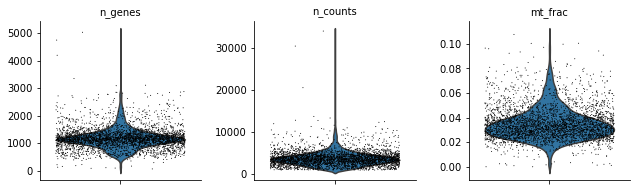

In [41]:
# Quality control - plot QC metrics
sc.pl.violin(adata, ['n_genes', 'n_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

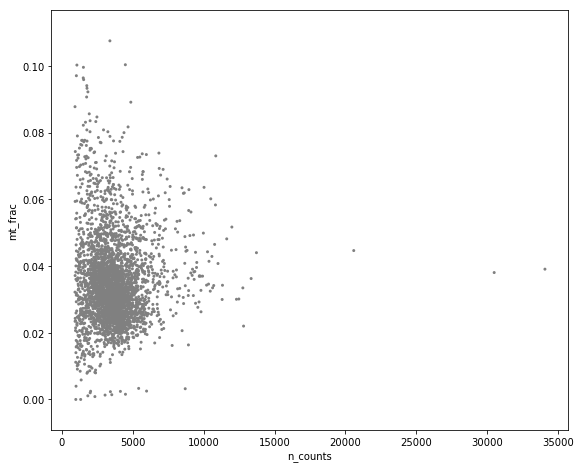

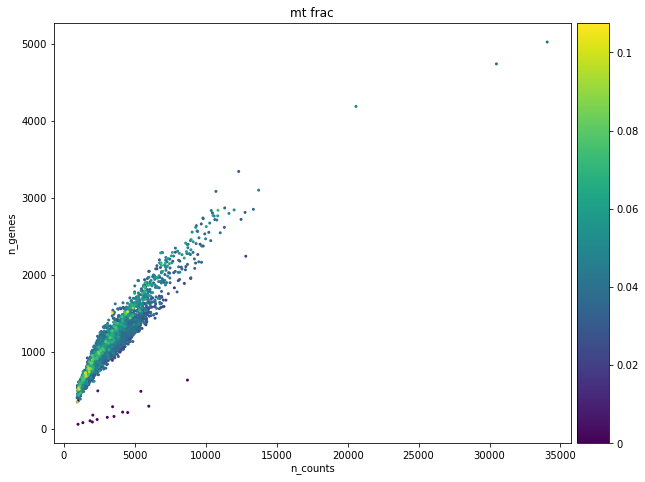

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


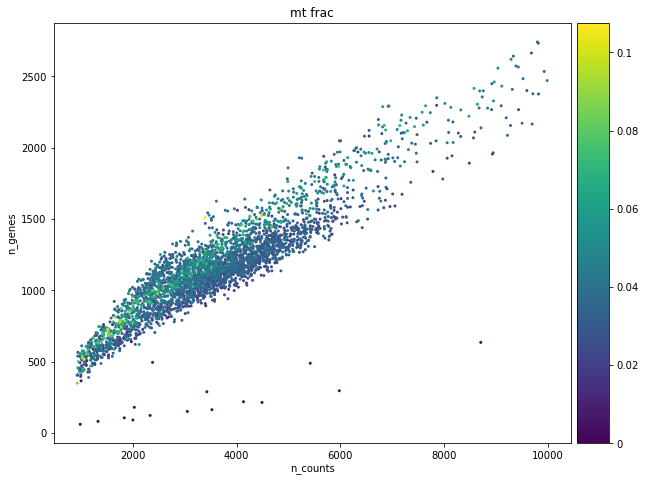

In [42]:
sc.pl.scatter(adata, x='n_counts', y='mt_frac')
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')
sc.pl.scatter(adata[adata.obs['n_counts'] < 10000], x='n_counts', y='n_genes', color='mt_frac')

There are a bunch of cells separating from the rest, with low number of genes and relatively high counts. We want to exclude them. Also, we exclude a couple of cells with very high n_genes and n_count, which could be doublets.

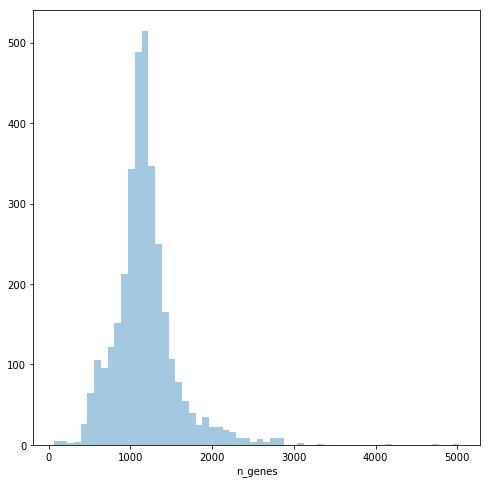

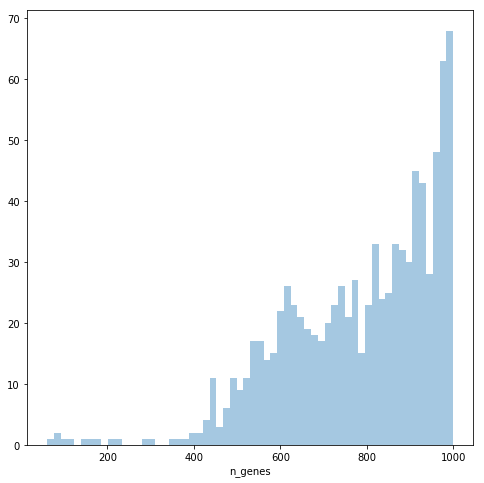

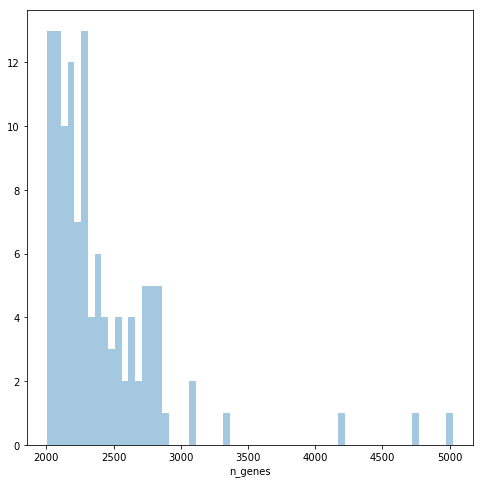

In [43]:
#Thresholding decision: genes
p1 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p2 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

p3 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']>2000], kde=False, bins=60)
plt.show()


In [44]:
# Thresholding on number of genes
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 400)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_genes = 3000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 3372
filtered out 16 cells that haveless than 400 genes expressed


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Number of cells after gene filter: 3356
filtered out 6 cells that havemore than 3000 genes expressed


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Number of cells after gene filter: 3350


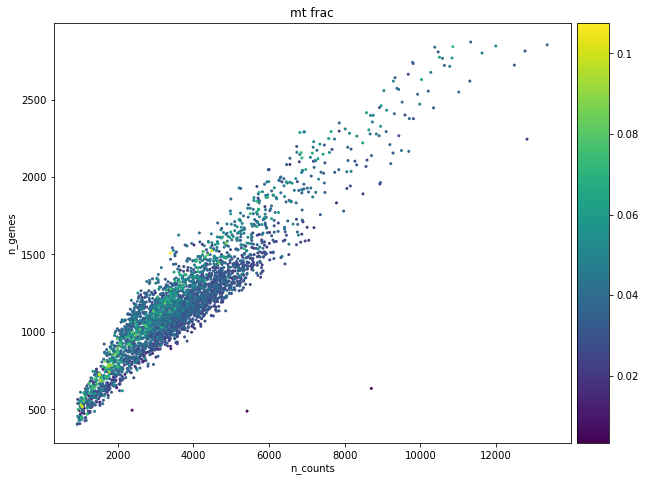

In [45]:
# Look at the effect of thresholding
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')


We still want to get rid of those 3 remaining cells which are clearly separating from the rest.

In [55]:
print('Total number of cells: {:d}'.format(adata.n_obs))
adata = adata[~((adata.obs['n_counts'] > 2000) & (adata.obs['n_genes'] < 500))]
print('Number of cells after filter: {:d}'.format(adata.n_obs))
adata = adata[~((adata.obs['n_counts'] > 8000) & (adata.obs['n_genes'] < 800))]
print('Number of cells after filter: {:d}'.format(adata.n_obs))

Total number of cells: 3350
Number of cells after filter: 3348
Number of cells after filter: 3347


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


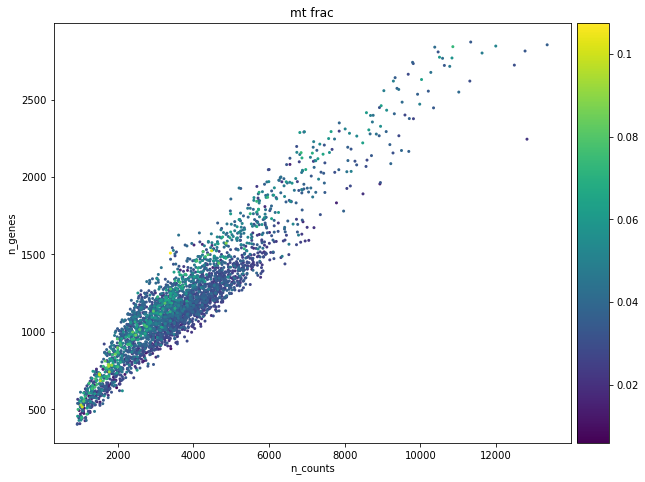

In [56]:
# Look at the effect of thresholding
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

There's no need of further filtering on mitochondrial fraction or number of counts.

In [57]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 58302
filtered out 45649 genes that are detectedin less than 20 cells
Number of genes after cell filter: 12653


## 1.2 Normalization

In [77]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


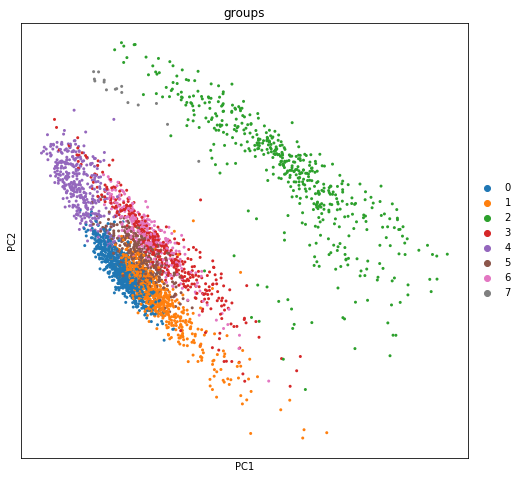

In [78]:
sc.pl.pca_scatter(adata_pp, color='groups')

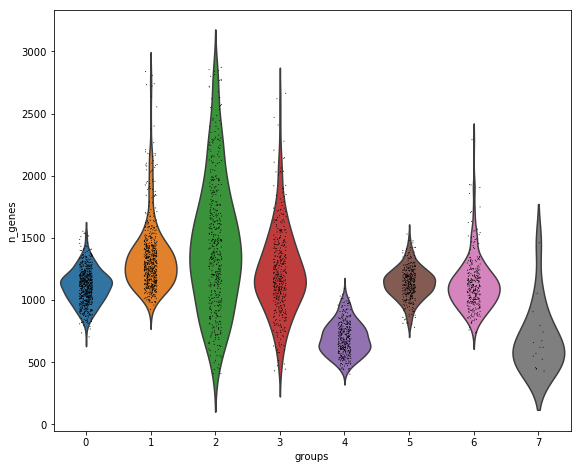

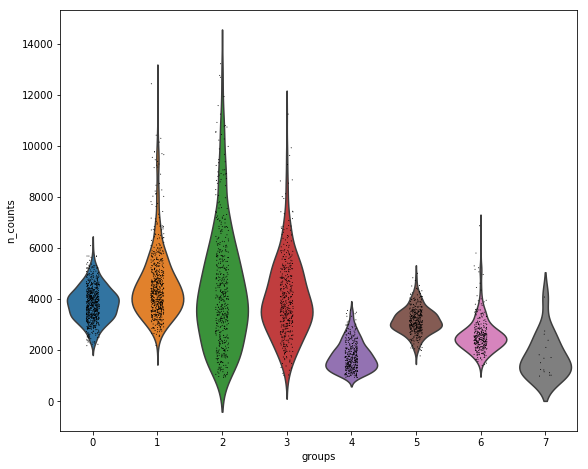

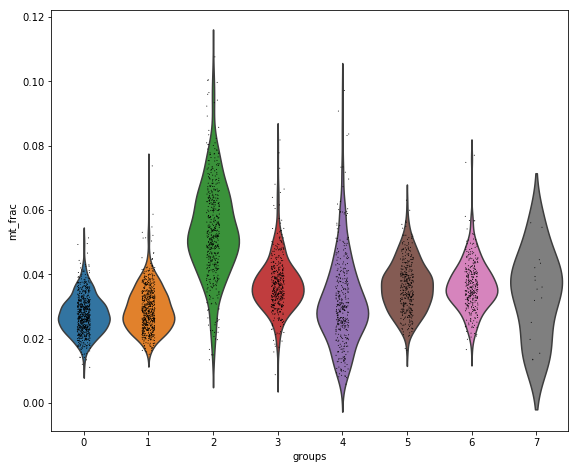

In [85]:
sc.pl.violin(adata_pp, 'n_genes', groupby= 'groups')
sc.pl.violin(adata_pp, 'n_counts', groupby= 'groups')
sc.pl.violin(adata_pp, 'mt_frac', groupby= 'groups')

In [86]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [89]:
sizes = input_groups.value_counts()

In [91]:
%%R -i data_mat -i input_groups -i sizes -o size_factors

size_factors = computeSumFactors(data_mat, sizes = sizes, clusters=input_groups, min.mean=0.1)

In [92]:
#Delete adata_pp
del adata_pp

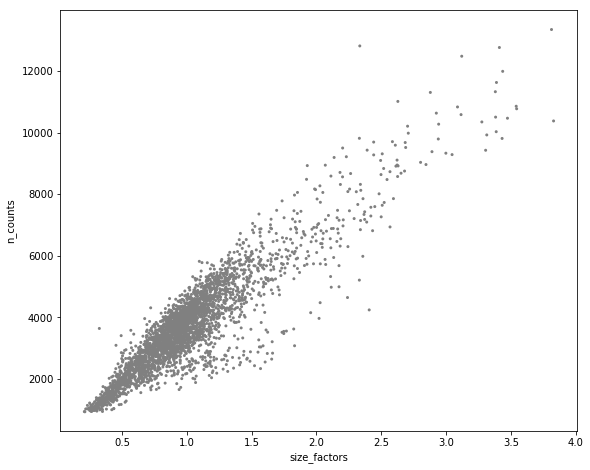

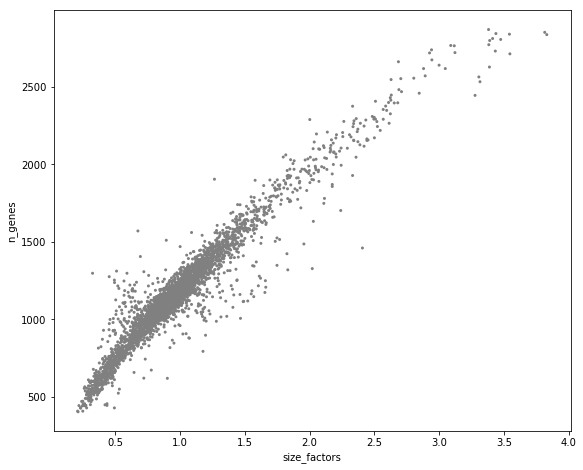

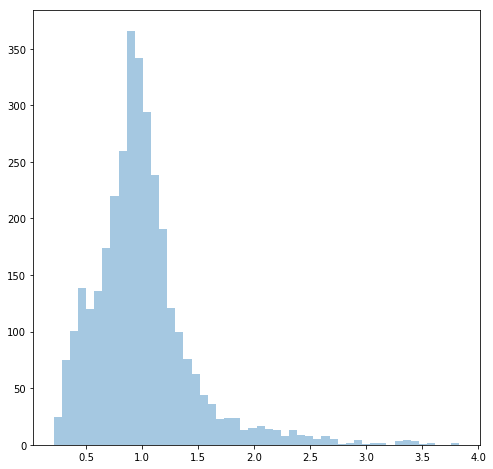

In [93]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [94]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [95]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [96]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## 1.3 Highly variable genes

In [97]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


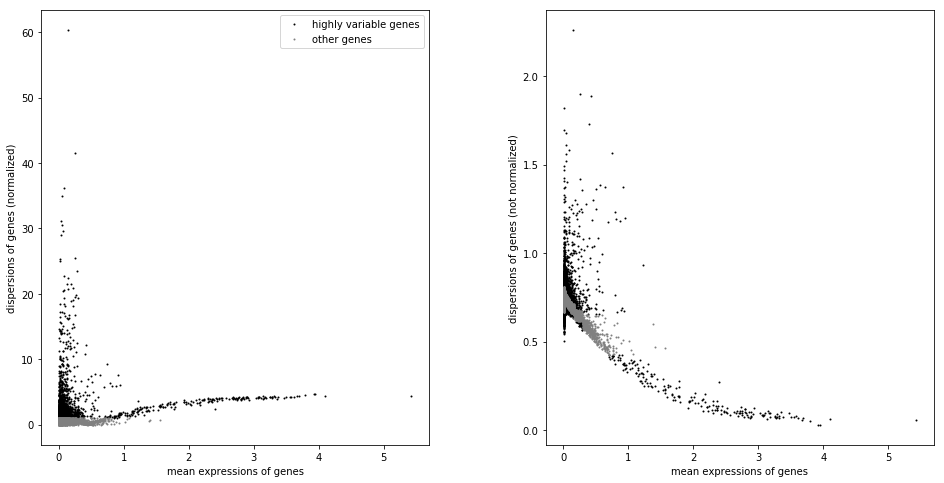

In [98]:
sc.pl.highly_variable_genes(adata)

# 2. Visualization

In [99]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP


/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished (0:00:10)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.99933493 0.99863505 0.98949564 0.98380107
     0.97812027 0.9567026  0.95293176 0.95225567 0.9277109  0.92100126
     0.9127575  0.9084045  0.89932895]
    finished (0:00:00)
drawing single-cell graph using layout 'fa'
    finished (0:00:32)


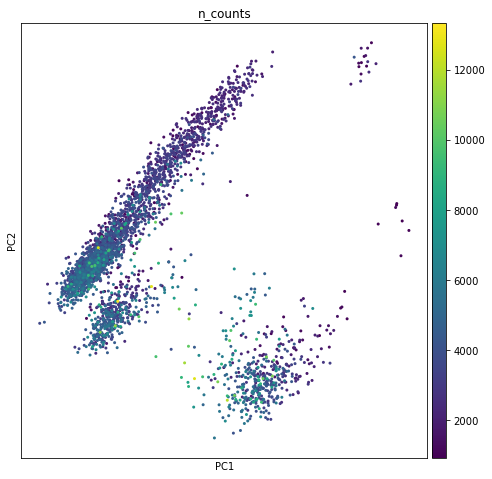

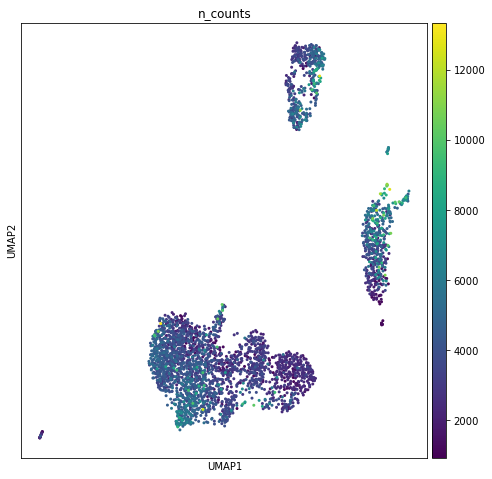

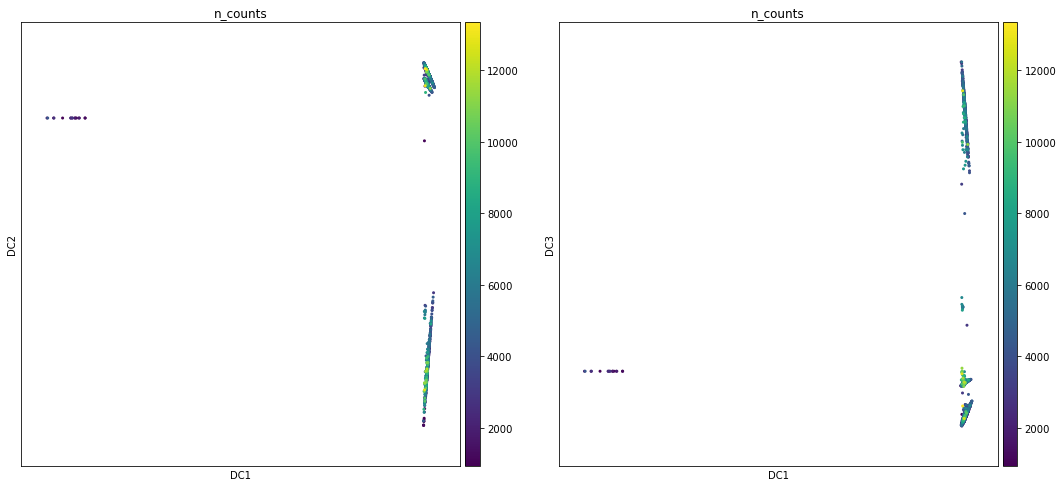

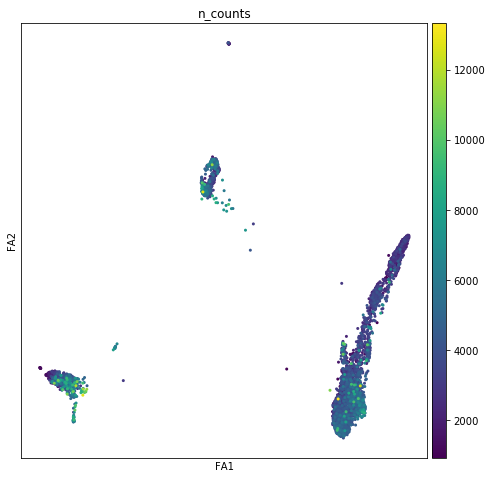

In [100]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

In [101]:
adata.write(results_file)

# 3. Clustering

In [102]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [103]:
adata.obs['louvain_r0.5'].value_counts()

0    818
1    757
2    486
3    482
4    427
5    361
6     16
Name: louvain_r0.5, dtype: int64

In [104]:
adata.obs['louvain_r1'].value_counts()

0     750
1     741
2     462
3     369
4     258
5     254
6     242
7     169
8      62
9      24
10     16
Name: louvain_r1, dtype: int64

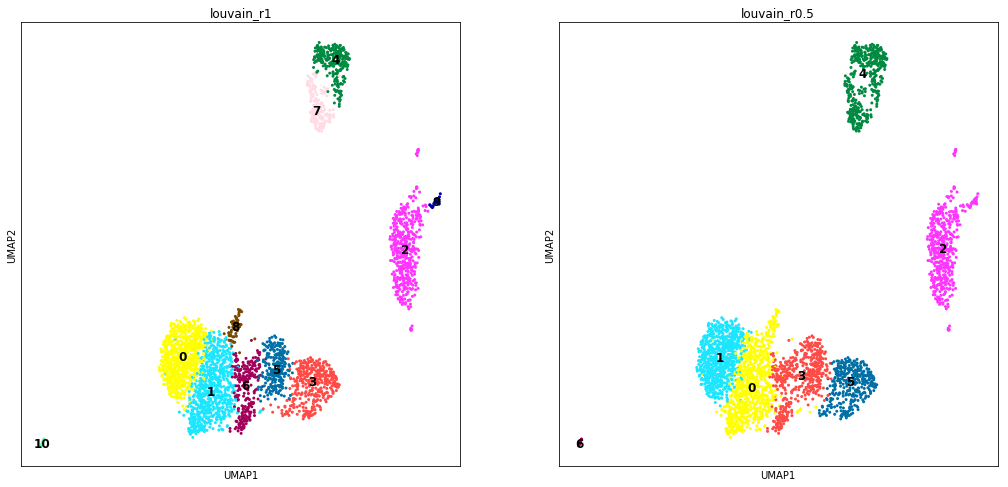

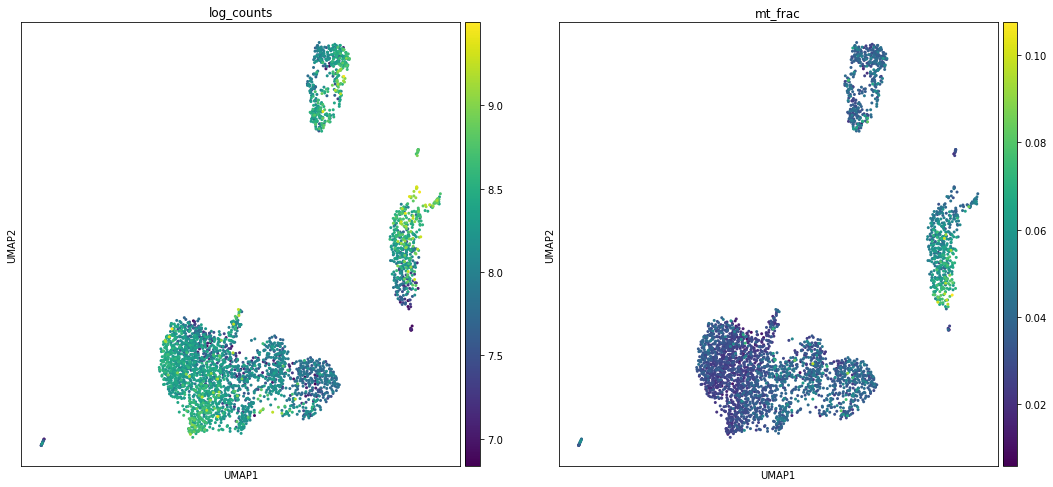

In [105]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])



# 4. Marker genes and cluster annotation (r 0.5)

## 4.1 Short list of cell types (PanglaoDB)

In [106]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished (0:00:02)


In [107]:
# Known marker genes taken from PanglaoDB (short list of 12 cell types)
markers_short_df = pd.read_csv('../../Munich/Immune_markers_short_12.txt', delimiter='\t')
markers_short_df.shape

(975, 14)

In [108]:
markers_short_df.head()

species official.gene.symbol cell.type         nicknames  \
417   Mm Hs                  CD2   B cells               NaN   
418   Mm Hs                  CD5   B cells               NaN   
419   Mm Hs                MS4A1   B cells   Bp35|MS4A2|CD20   
420   Mm Hs                  CR2   B cells         CD21|C3DR   
421   Mm Hs                 CD22   B cells  SIGLEC-2|SIGLEC2   

     ubiquitousness.index             product.description  \
417                 0.040                    CD2 molecule   
418                 0.004                    CD5 molecule   
419                 0.014  membrane spanning 4-domains A1   
420                 0.001       complement C3d receptor 2   
421                 0.003                   CD22 molecule   

               gene.type  canonical.marker germ.layer          organ  \
417  protein-coding gene               NaN   Mesoderm  Immune system   
418  protein-coding gene               1.0   Mesoderm  Immune system   
419  protein-coding gene               1.0   Mesoderm  Immune system   
420  protein-coding gene               1.0   Mesoderm  Immune system   
421  protein-coding gene               1.0   Mesoderm  Immune system   

     sensitivity_human  sensitivity_mouse  specificity_human  \
417           0.000000           0.212355           0.095847   
418           0.000000           0.000000           0.004153   
419           0.483871           0.617761           0.011182   
420           0.048387           0.034749           0.000000   
421           0.096774           0.127413           0.001278   

     specificity_mouse  
417           0.026556  
418           0.004502  
419           0.001566  
420           0.000000  
421           0.000196

Select only genes that are annotated for human:

In [109]:
markers_short_df_hum = markers_short_df[(markers_short_df['species'] == 'Hs') | (markers_short_df['species'] == 'Mm Hs')]
markers_short_df_hum.shape

(892, 14)

In [110]:
cell_types = list(markers_short_df_hum['cell.type'].unique())

In [111]:
markers_dict = {}

In [112]:
for ctype in cell_types:
    df = markers_short_df_hum[markers_short_df_hum['cell.type'] == ctype]
    markers_dict[ctype] = df['official.gene.symbol'].to_list()

In [113]:
cell_annotation = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r0.5')
cell_annotation
    

0    1     2     3     4  \
B cells                                        3.0  1.0   2.0   2.0  37.0   
B cells naive                                  3.0  0.0   0.0   1.0  29.0   
Dendritic cells                                0.0  1.0  13.0   6.0  12.0   
Erythroid-like and erythroid precursor cells   0.0  0.0   3.0   0.0   0.0   
Gamma delta T cells                            1.0  0.0   0.0  12.0   0.0   
Monocytes                                      1.0  0.0  13.0   3.0   3.0   
NK cells                                       3.0  0.0   1.0  25.0   1.0   
Plasmacytoid dendritic cells                   0.0  1.0   2.0   2.0   8.0   
Platelets                                      0.0  0.0   5.0   2.0   3.0   
T cells                                       12.0  4.0   1.0  25.0   3.0   
T cytotoxic cells                              2.0  0.0   0.0   4.0   0.0   
T memory cells                                 9.0  4.0   2.0   7.0   1.0   

                                                 5     6  
B cells                                        0.0   0.0  
B cells naive                                  0.0   0.0  
Dendritic cells                                4.0   0.0  
Erythroid-like and erythroid precursor cells   1.0   3.0  
Gamma delta T cells                           19.0   1.0  
Monocytes                                      4.0   0.0  
NK cells                                      26.0   2.0  
Plasmacytoid dendritic cells                   1.0   1.0  
Platelets                                      6.0  27.0  
T cells                                       17.0   1.0  
T cytotoxic cells                              1.0   0.0  
T memory cells                                 4.0   1.0

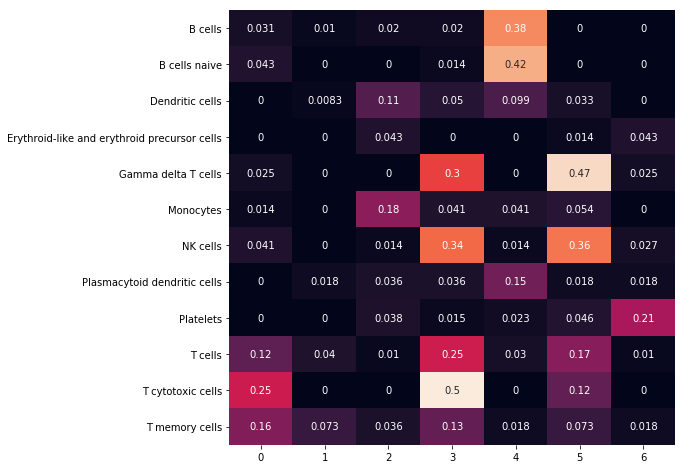

In [114]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [115]:
#Categories to rename
adata.obs['louvain_r0.5'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6'], dtype='object')

In [116]:
adata.obs['cell_type0.5short'] = adata.obs['louvain_r0.5']
adata.obs['cell_type0.5short'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6'], dtype='object')

In [118]:
adata.rename_categories('cell_type0.5short', ['T cytotoxic 1', 'T memory', 'Monocytes + dendritic', 'T cytotoxic + NK', 'B cells', 'Gamma delta + NK', 'Platelets'])

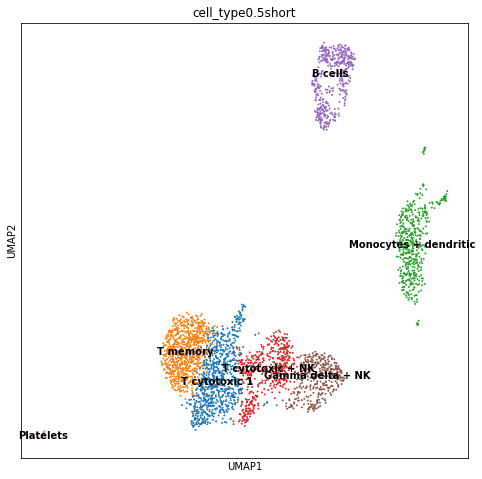

In [119]:
sc.pl.umap(adata, color='cell_type0.5short', size=15, legend_loc='on data')

## 4.2 Long list of cell types
Here we try using the long list of cell types (29) from PanglaoDB, considering all cell types in "immune system" + "blood". We manually checked that all cell types were possible for healthy tissue, so we excluded:
* __Myeloid derived suppressor cells__, description: MDSC are not present at steady state in healthy individuals and appear in cancer and pathological conditions associated with chronic inflammation or stress. 
* __Red pulp macrophages__, description: Present in the red pulp of the spleen. They are necessary for maintaining blood homeostasis by performing phagocytosis upon injured and senescent erythrocytes and blood-borne particulates.

In [120]:
markers_long_df = pd.read_csv('../../Munich/Immune_markers_long_29.txt', delimiter='\t')
markers_long_df.shape

(1866, 14)

In [121]:
markers_long_df = markers_long_df[markers_long_df['cell.type'] != 'Myeloid-derived suppressor cells']
markers_long_df.shape

(1849, 14)

In [122]:
markers_long_df = markers_long_df[markers_long_df['cell.type'] != 'Red pulp macrophages']
markers_long_df.shape

(1837, 14)

In [123]:
markers_long_df_hum = markers_long_df[(markers_long_df['species'] == 'Hs') | (markers_long_df['species'] == 'Mm Hs')]
markers_long_df_hum.shape

(1685, 14)

In [124]:
cell_types = list(markers_long_df_hum['cell.type'].unique())

In [125]:
markers_dict_long = {}
for ctype in cell_types:
    df = markers_long_df_hum[markers_long_df_hum['cell.type'] == ctype]
    markers_dict_long[ctype] = df['official.gene.symbol'].to_list()

In [126]:
cell_annotation_long = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r0.5')

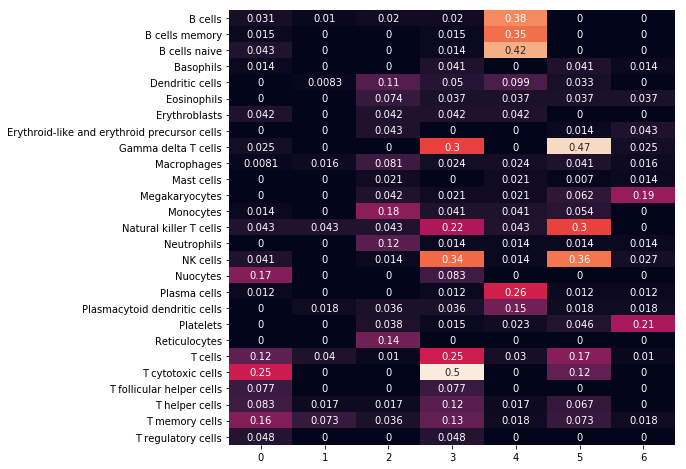

In [127]:
cell_annotation_long_norm = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_long_norm, cbar=False, annot=True)

Using the long list did NOT actually improve the annotation

# 5. Markers and cluster annotation (r 1)

In [128]:
#Calculate marker genes r1
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')
cell_annotation_long_r1 = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r1')

ranking genes
    finished (0:00:03)


## 5.1 Short list of cell types

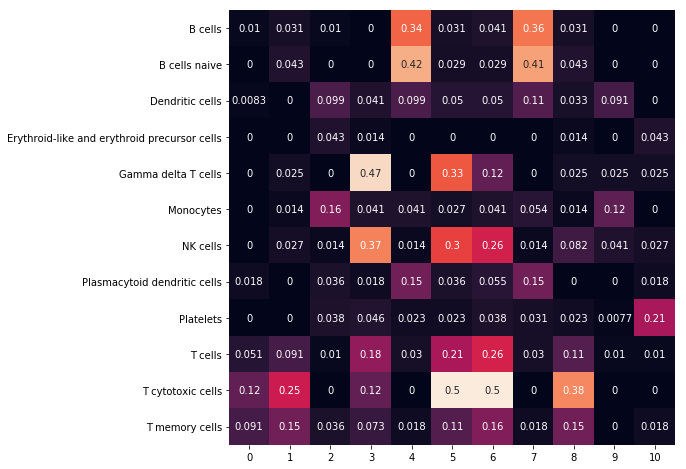

In [129]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [131]:
# Categories to rename
adata.obs['cell_type1short'] = adata.obs['louvain_r1']
adata.rename_categories('cell_type1short', ['T cytotoxic 1','T cytotoxic 2', 'Monocytes + dendritic', 'Gamma delta + NK', 'B cells1', 'T cytotoxic + NK + gammadelta', 'T cytotoxic + NK', 'B cells2', 'T cytotox 3', 'Mono + dendr','Platelets'])

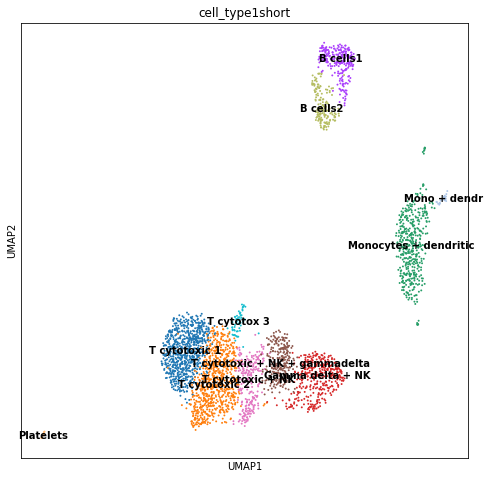

In [132]:
sc.pl.umap(adata, color='cell_type1short', size=15, legend_loc='on data')

## 5.2 Long list of cell types

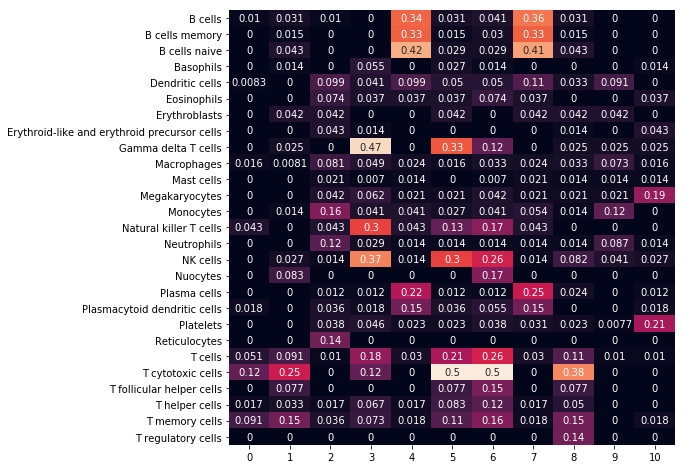

In [133]:
cell_annotation_long_norm_r1 = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_long_norm_r1, cbar=False, annot=True)

In [134]:
adata.write(results_file)

# 6. Plot makers of subtypes

In [135]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## T cells

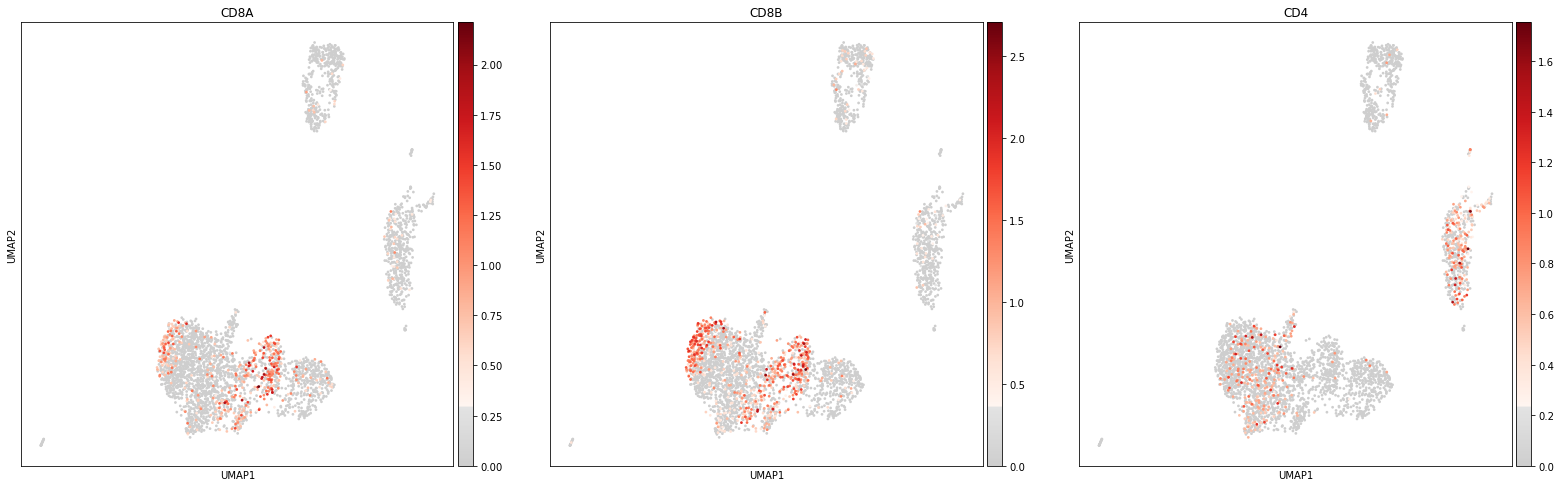

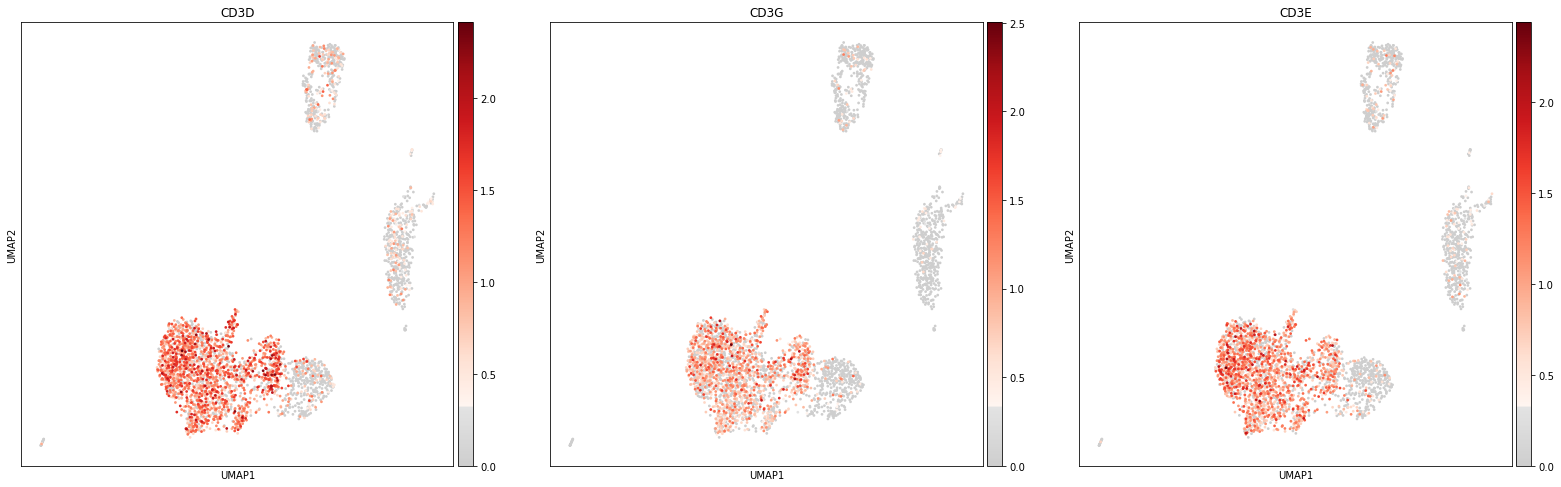

In [138]:
#Canonical markers
sc.pl.umap(adata, color=['CD8A','CD8B', 'CD4'], use_raw=False, color_map=mymap, size = 30)
sc.pl.umap(adata, color=['CD3D', 'CD3G', 'CD3E'], use_raw=False, color_map=mymap, size = 30)

Cluster 3 (louvain r1) is CD8- CD4- CD3- (?gamma delta?). Cluster 0 (r1) seems to contain both CD8+ and CD4+ cells. May need to subcluster.

### Natural killer T cells

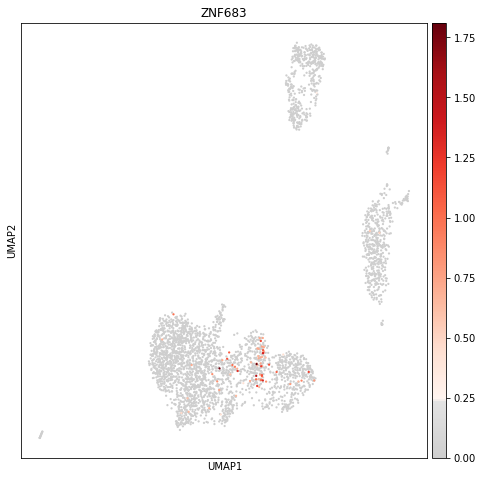

In [140]:
sc.pl.umap(adata, color=['ZNF683'], use_raw=False, color_map=mymap, size = 20)

NKT are present in clust 5 (r1). Marker from[Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

### T regulatory cells

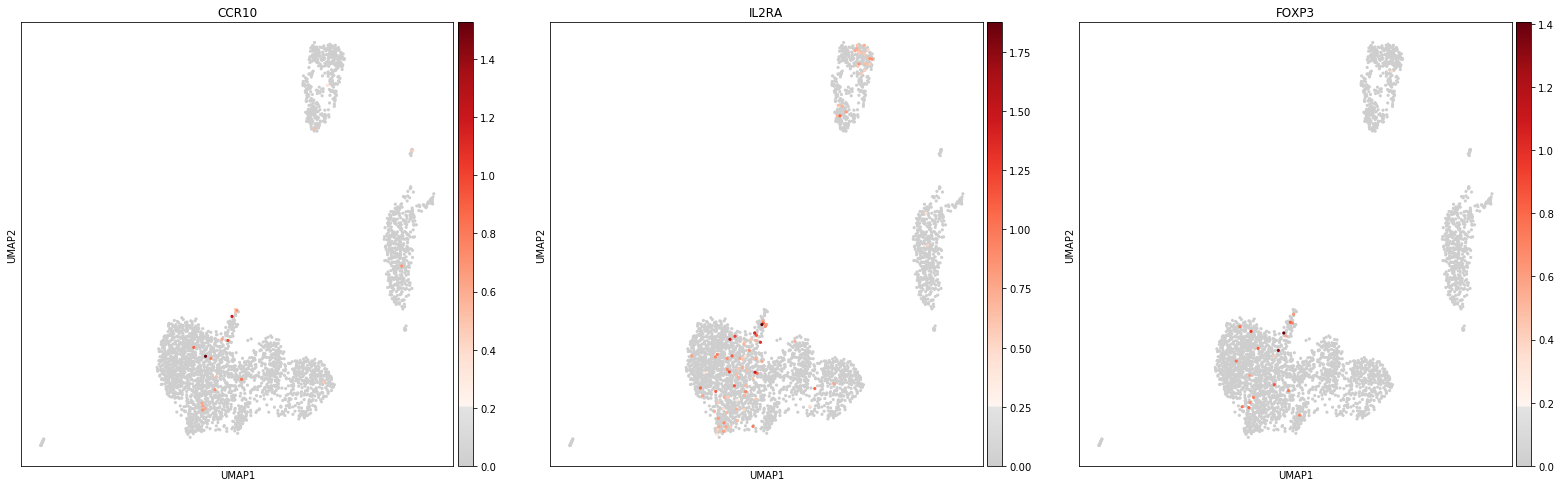

In [143]:
#Canonical markers
sc.pl.umap(adata, color=['CCR10','IL2RA', 'FOXP3'], use_raw=False, color_map=mymap, size = 40)


Cluster 1 and 8(r1) are also CD4+, so few T reg! [Ballke et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4751285/)

### T memory cells

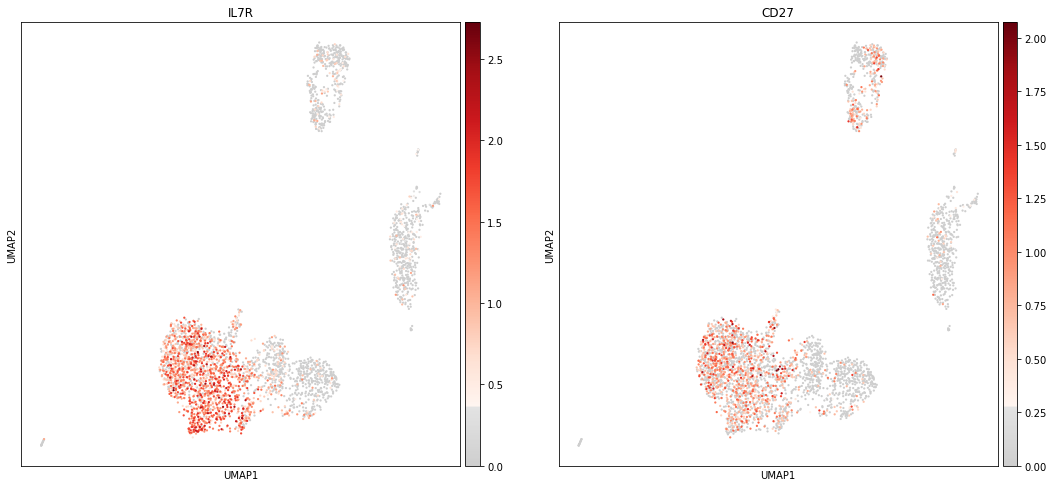

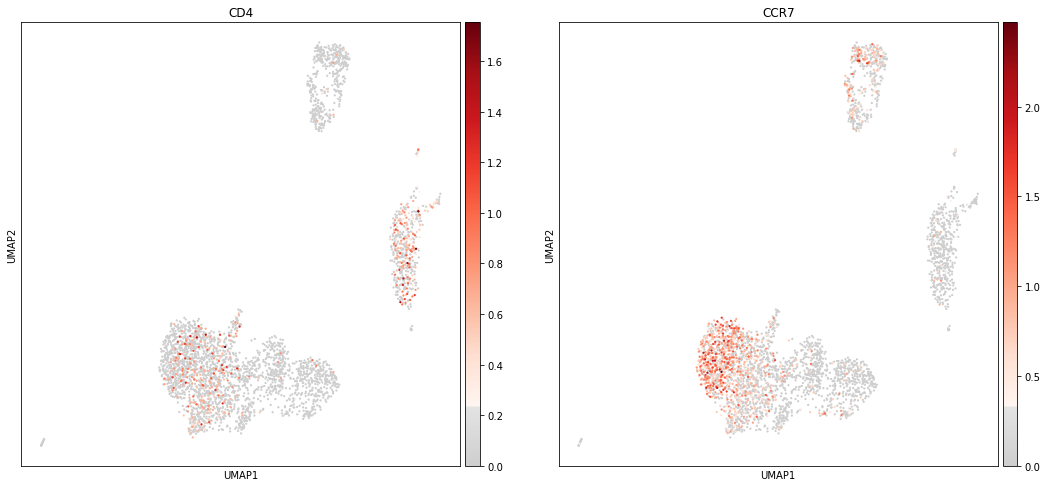

In [144]:
sc.pl.umap(adata, color=['IL7R','CD27'], use_raw=False, color_map=mymap, size = 20)
sc.pl.umap(adata, color=['CD4', 'CCR7'], use_raw=False, color_map=mymap, size = 20)


Clusters 1 and 0 are clearly enriched with CD4+ T mem. (from [CellMarker](http://biocc.hrbmu.edu.cn/CellMarker/search.jsp?species=Human&tissue=Blood&cellname=T%20cell))

### Naive CD8+ T cells

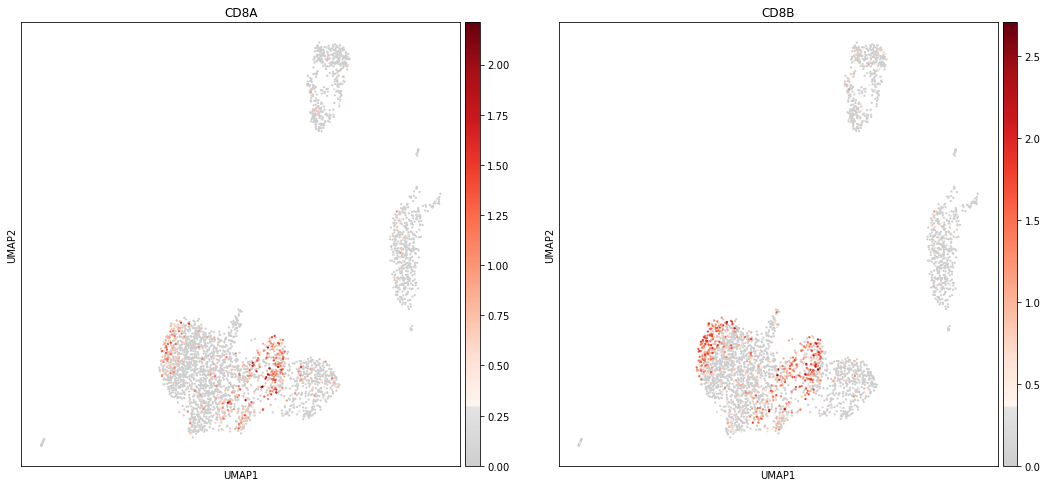

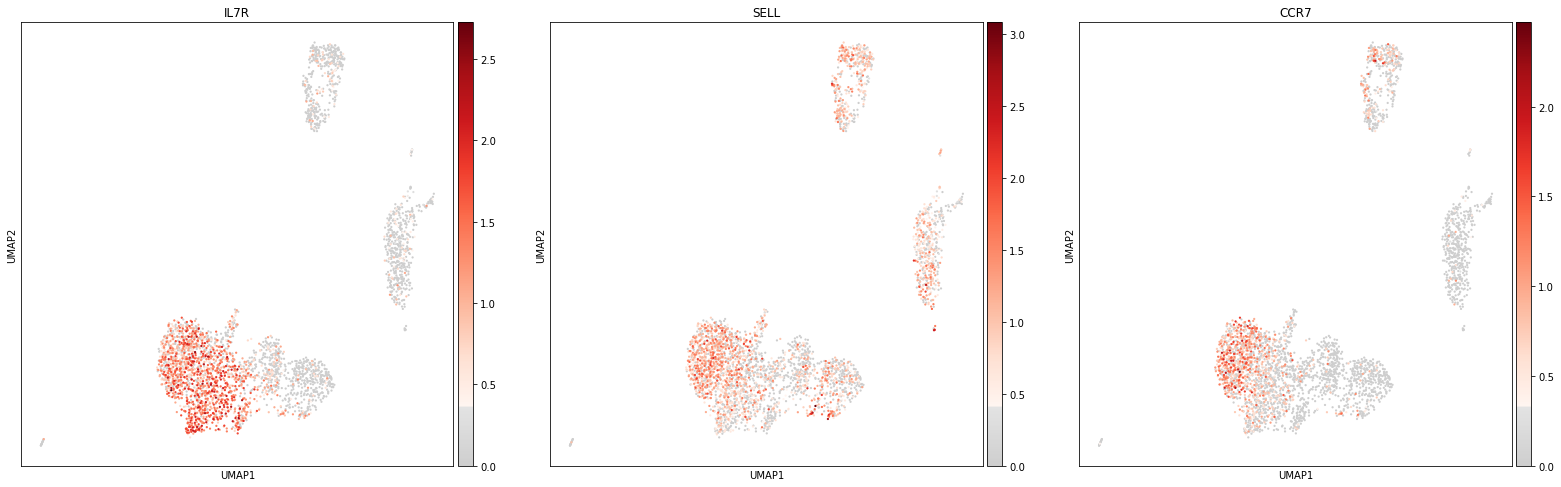

In [145]:
sc.pl.umap(adata, color=['CD8A','CD8B'], use_raw=False, color_map=mymap, size = 20)
sc.pl.umap(adata, color=['IL7R', 'SELL', 'CCR7'], use_raw=False, color_map=mymap, size = 20)

Left part of cluster 0 is CD8+ Naive T cells [Samji et al.](https://www.ncbi.nlm.nih.gov/pubmed/28274794)

### Cytotoxic T cells

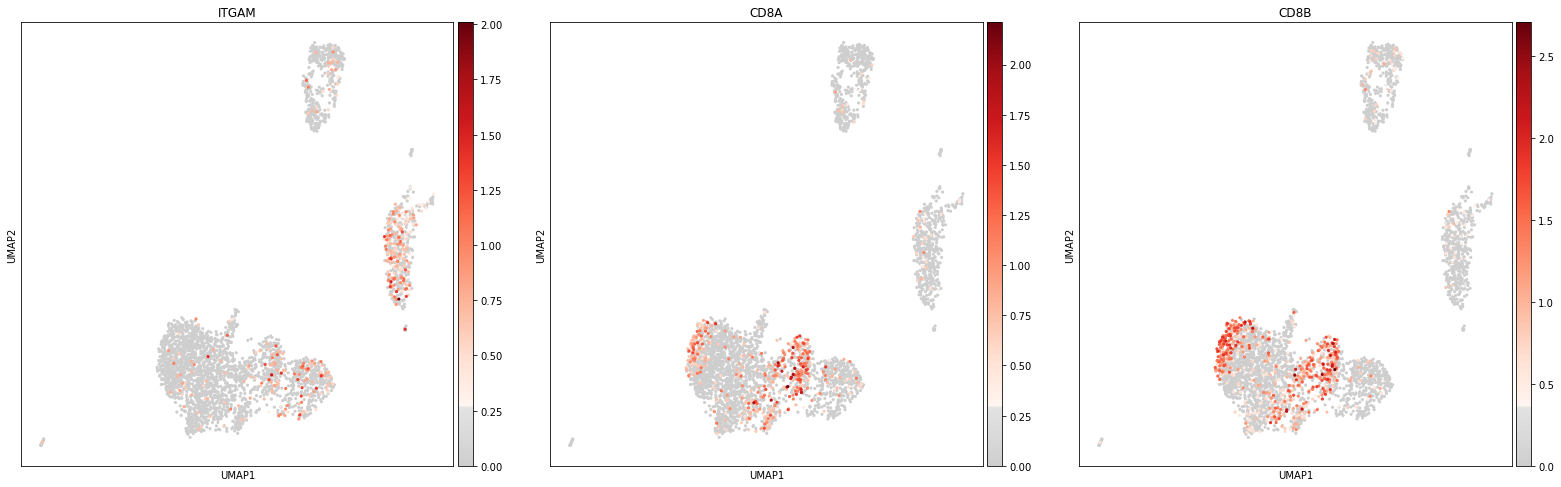

In [147]:
sc.pl.umap(adata, color=['ITGAM','CD8A', 'CD8B'], use_raw=False, color_map=mymap, size = 40)

Cluster 5 is also Cytotoxic T cells ([CellMarker](http://biocc.hrbmu.edu.cn/CellMarker/search.jsp?species=Human&tissue=Blood&cellname=T%20cell))

### Gamma delta T cells

!!!! Look for more markers

## NK cells

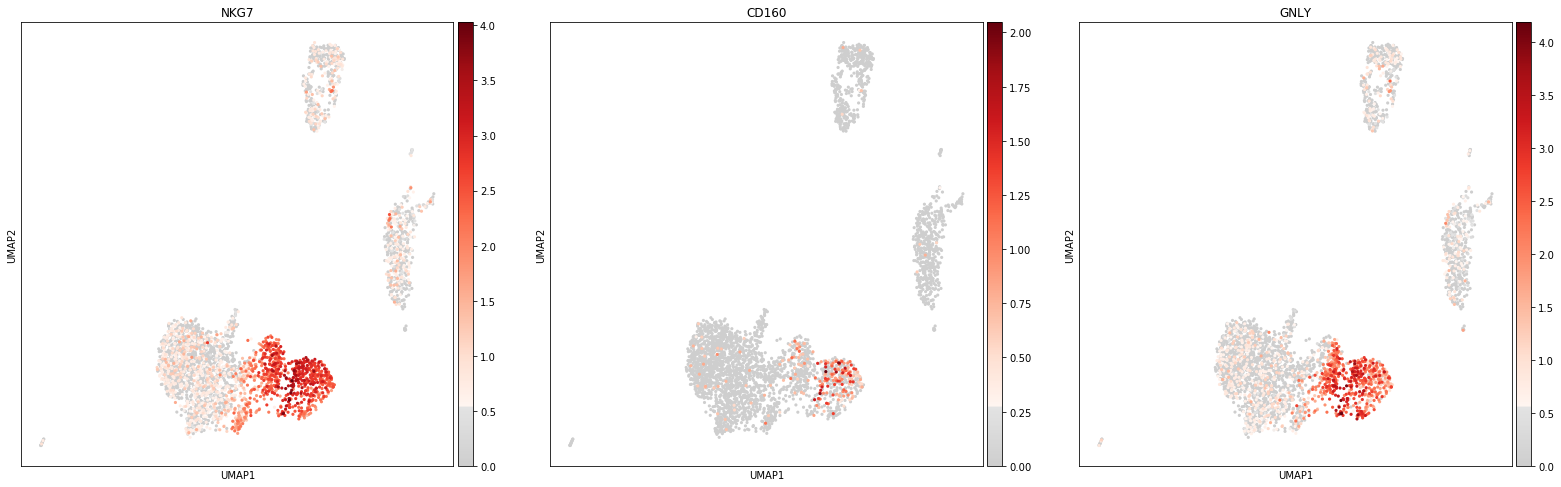

In [148]:
sc.pl.umap(adata, color=['NKG7','CD160', 'GNLY'], use_raw=False, color_map=mymap, size = 40)

Clusters 3, 5 and 6 are enriched with NK cells (Sinha et al)

## Monocytes: CD14+ and CD16+

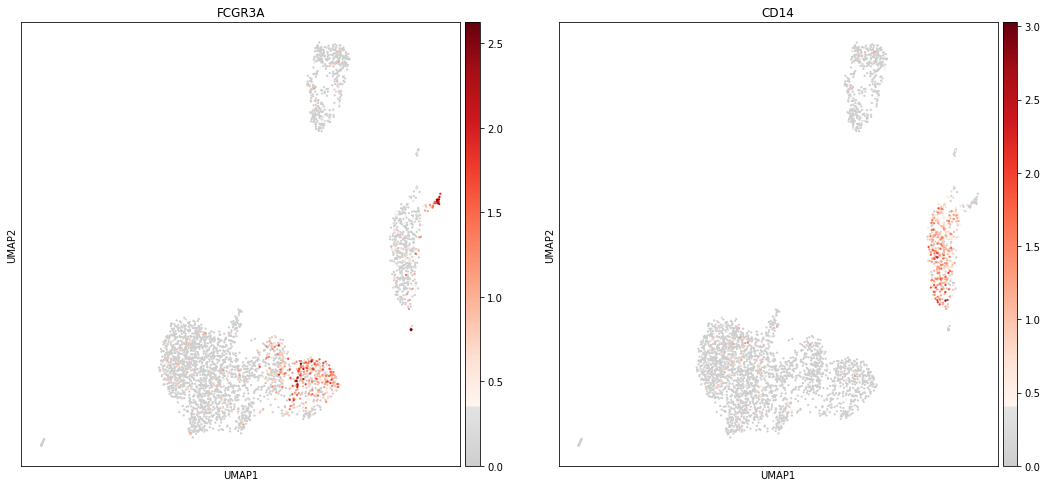

In [149]:
sc.pl.umap(adata, color=['FCGR3A','CD14'], use_raw=False, color_map=mymap, size = 20)

## Monocyte-derived Dendritic cells

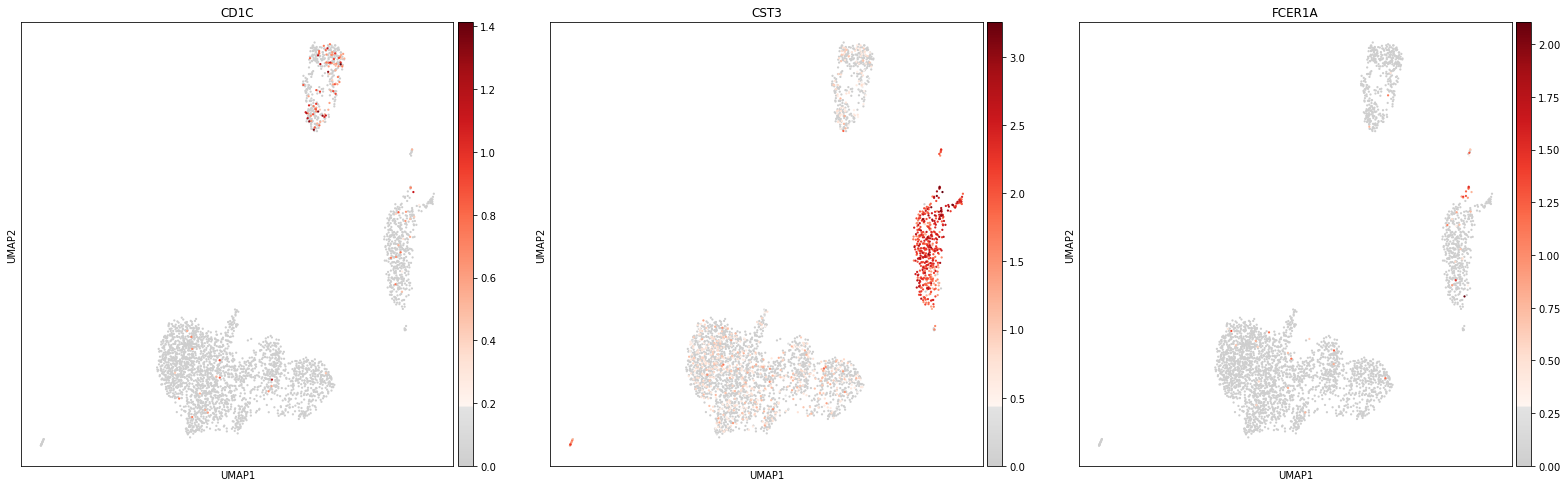

In [150]:
sc.pl.umap(adata, color=['CD1C', 'CST3', 'FCER1A'], use_raw=False, color_map=mymap, size = 20)

Apparently very few cells at the top of cluster 2.  [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

## B cells

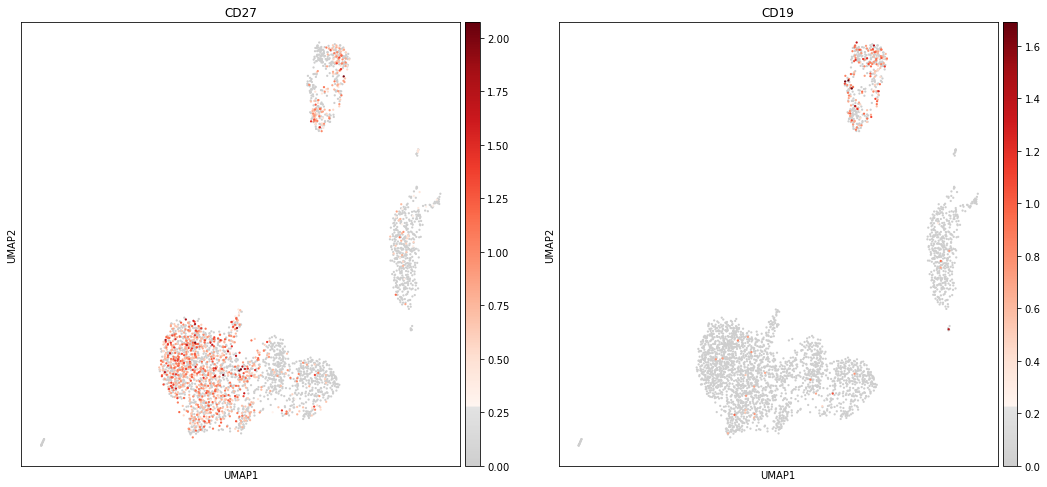

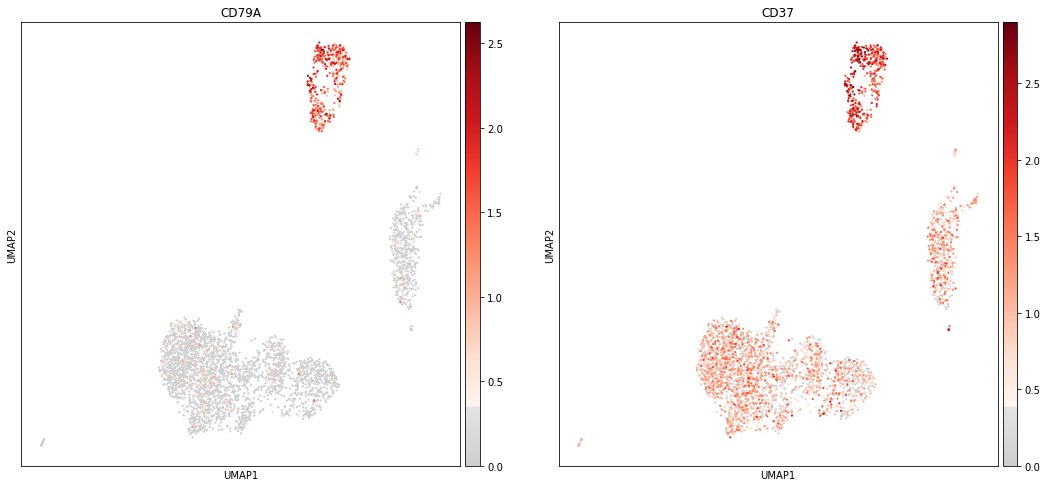

In [151]:
sc.pl.umap(adata, color=['CD27', 'CD19'], use_raw=False, color_map=mymap, size = 20)
sc.pl.umap(adata, color=['CD79A', 'CD37'], use_raw=False, color_map=mymap, size = 20)

First 2 markers are from CellMarker, second 2 from Sinha et al.

# 7. Subclustering

We subcluster starting from louvain_r0.5 and consider clusters 1 and 2.

In [191]:
#Subcluster cluster1
sc.tl.louvain(adata, restrict_to=('louvain_r0.5', ['1']), resolution=0.5, key_added='louvain0.5_clust1_sub')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [192]:
#Show the new clustering
if 'louvain0.5_clust1_sub_colors' in adata.uns:
    del adata.uns['louvain0.5_clust1_sub_colors']

sc.pl.umap(adata, color='louvain0.5_clust1_sub', size = 20, legend_loc = 'on data', palette=sc.pl.palettes.godsnot_64)

In [197]:
#Subcluster cluster2
sc.tl.louvain(adata, restrict_to=('louvain_r0.5', ['2']), resolution=0.2, key_added='louvain0.5_clust2_sub')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


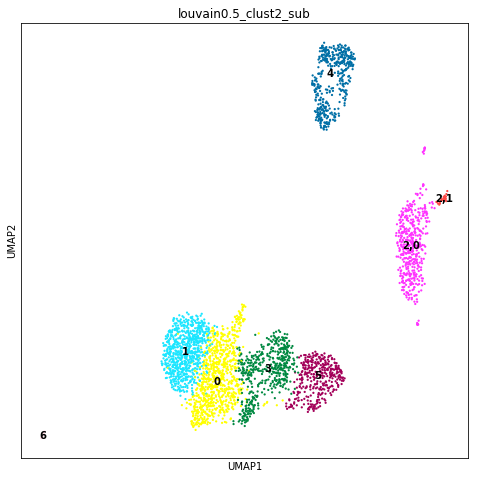

In [198]:
#Show the new clustering
if 'louvain0.5_clust2_sub_colors' in adata.uns:
    del adata.uns['louvain0.5_clust2_sub_colors']

sc.pl.umap(adata, color='louvain0.5_clust2_sub', size = 20, legend_loc = 'on data', palette=sc.pl.palettes.godsnot_64)

Subclustering cluster 2 worked out fine, separating CD16+ monocytes from CD14+. Cluster 1 instead, is not well separated in CD8+ vs CD4+, so we consider it as one.

# 8. Final cell-type annotation

In [199]:
# Categories to rename
adata.obs['final_annotation'] = adata.obs['louvain0.5_clust2_sub']
adata.rename_categories('final_annotation', ['CD4+ T memory', 'CD4+ T memory + CD8+ T naive', 'CD14+ Monocytes', 'CD16+ Monocytes', 'NKT + NK cells', 'B cells', 'NK cells', 'Platelets'])

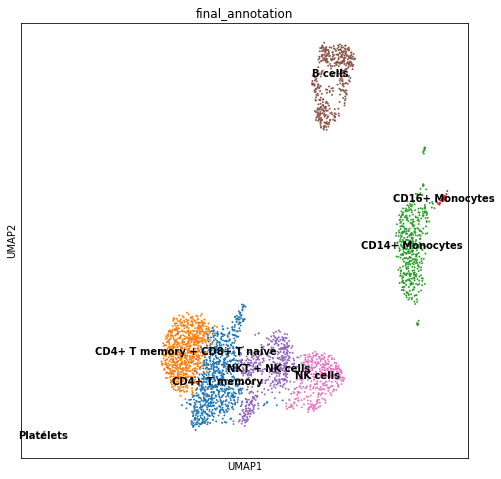

In [200]:
sc.pl.umap(adata, color='final_annotation', size=15, legend_loc='on data')

In [201]:
# save final result
adata.write(results_file)